In [10]:
import pandas as pd
import mysql.connector
import os
import numpy as np

# --- Configuration ---
# List of CSV files and their corresponding table names
CSV_FILES_TO_PROCESS = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('order_items.csv', 'order_items'),
    ('payments.csv', 'payments')
]

# Database connection details
DB_CONFIG = {
    'host': 'localhost',
    'user': 'root',
    'password': '12345678',
    'database': 'Target'
}

# Folder containing the CSV files
CSV_FOLDER_PATH = '/Users/princekumar/Downloads/Target'

# NEW: Define a batch size for insertions to avoid 'max_allowed_packet' errors
BATCH_SIZE = 10000 

def get_sql_type(dtype):
    """Maps pandas dtype to a corresponding MySQL data type."""
    if pd.api.types.is_integer_dtype(dtype):
        return 'BIGINT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'DOUBLE'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    # MODIFIED: Use TEXT for object types to avoid length issues with VARCHAR(255).
    # This is safer for columns with unpredictable string lengths.
    return 'TEXT'

def clean_column_names(df):
    """Cleans DataFrame column names to be SQL-friendly."""
    original_columns = df.columns
    new_columns = [col.strip().replace(' ', '_').replace('-', '_').replace('.', '_') for col in original_columns]
    df.columns = new_columns
    return df

def main():
    """
    Main function to connect to the database, process CSV files,
    and insert data into MySQL tables using batching.
    """
    conn = None
    try:
        # Connect to the MySQL database
        conn = mysql.connector.connect(**DB_CONFIG)
        cursor = conn.cursor()
        print("✅ Successfully connected to the database.")

        for csv_file, table_name in CSV_FILES_TO_PROCESS:
            file_path = os.path.join(CSV_FOLDER_PATH, csv_file)
            
            if not os.path.exists(file_path):
                print(f"--- ⚠️ WARNING: File not found, skipping: {file_path} ---")
                continue

            print(f"\n--- Processing {csv_file} -> `{table_name}` table ---")

            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(file_path)

            # Clean column names
            df = clean_column_names(df)

            # Generate and execute the CREATE TABLE statement
            columns_with_types = ', '.join(
                f"`{col}` {get_sql_type(df[col].dtype)}" for col in df.columns
            )
            create_table_query = f"CREATE TABLE IF NOT EXISTS `{table_name}` ({columns_with_types})"
            print("Creating table if it does not exist...")
            cursor.execute(create_table_query)

            # Prepare for insertion
            cols = ', '.join([f"`{col}`" for col in df.columns])
            placeholders = ', '.join(['%s'] * len(df.columns))
            insert_query = f"INSERT INTO `{table_name}` ({cols}) VALUES ({placeholders})"

            # Replace pandas NaN/NaT with None (SQL NULL)
            df_for_insert = df.replace({np.nan: None, pd.NaT: None})
            
            # Convert DataFrame to a list of tuples for insertion
            data_to_insert = [tuple(row) for row in df_for_insert.itertuples(index=False)]
            
            # --- MODIFIED: Insert data in batches ---
            print(f"Preparing to insert {len(data_to_insert)} rows in batches of {BATCH_SIZE}...")
            
            for i in range(0, len(data_to_insert), BATCH_SIZE):
                batch = data_to_insert[i:i + BATCH_SIZE]
                print(f"  -> Inserting batch {i // BATCH_SIZE + 1}...")
                cursor.executemany(insert_query, batch)
                conn.commit() # Commit after each batch

            print(f"✅ Successfully inserted all data into `{table_name}`.")

    except mysql.connector.Error as err:
        print(f"❌ Database error: {err}")
        if conn and conn.is_connected():
            print("Rolling back transaction...")
            conn.rollback()
    except FileNotFoundError as err:
        print(f"❌ File error: {err}")
    except Exception as err:
        print(f"❌ An unexpected error occurred: {err}")
    finally:
        # Close the connection
        if conn and conn.is_connected():
            cursor.close()
            conn.close()
            print("\nDatabase connection closed.")

if __name__ == "__main__":
    main()

✅ Successfully connected to the database.

--- Processing customers.csv -> `customers` table ---
Creating table if it does not exist...
Preparing to insert 99441 rows in batches of 10000...
  -> Inserting batch 1...
  -> Inserting batch 2...
  -> Inserting batch 3...
  -> Inserting batch 4...
  -> Inserting batch 5...
  -> Inserting batch 6...
  -> Inserting batch 7...
  -> Inserting batch 8...
  -> Inserting batch 9...
  -> Inserting batch 10...
✅ Successfully inserted all data into `customers`.

--- Processing orders.csv -> `orders` table ---
Creating table if it does not exist...
Preparing to insert 99441 rows in batches of 10000...
  -> Inserting batch 1...
  -> Inserting batch 2...
  -> Inserting batch 3...
  -> Inserting batch 4...
  -> Inserting batch 5...
  -> Inserting batch 6...
  -> Inserting batch 7...
  -> Inserting batch 8...
  -> Inserting batch 9...
  -> Inserting batch 10...
✅ Successfully inserted all data into `orders`.

--- Processing sellers.csv -> `sellers` table 

In [7]:
pip install mysql-connector-python


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

# Establish the database connection
# Note: Replace "your_password" with your actual MySQL password.
try:
    db = mysql.connector.connect(
        host="localhost",
        username="root",
        password="12345678",
        database="Target"
    )
    cur = db.cursor()
    print("Database connection successful.")
except mysql.connector.Error as err:
    print(f"Error connecting to the database: {err}")
    print("Please ensure your MySQL server is running and you have replaced 'your_password' with your actual password.")
    # We will exit here as subsequent code will fail without a database connection.
    exit()



Database connection successful.


In [4]:

print("-- Unique Customer Cities ---")
query_1 = "SELECT DISTINCT customer_city FROM customers;"
cur.execute(query_1)
data_1 = cur.fetchall()
df_1 = pd.DataFrame(data_1, columns=['customer_city'])
print(df_1.head())



-- Unique Customer Cities ---
           customer_city
0                 franca
1  sao bernardo do campo
2              sao paulo
3        mogi das cruzes
4               campinas


In [5]:

print("---Task 2: Total Orders in 2016 ---")
query_2 = "SELECT COUNT(order_id) FROM orders WHERE YEAR(order_purchase_timestamp) = 2016;"
cur.execute(query_2)
data_2 = cur.fetchone()
print(f"Total orders placed in 2016: {data_2[0]}")


---Task 2: Total Orders in 2016 ---
Total orders placed in 2016: 2303


In [6]:
print("--- Total Sales per Category ---")
query_3 = """
SELECT UPPER(p.product_category) AS category, 
       ROUND(SUM(pay.payment_value), 2) AS sales
FROM products p
JOIN order_items oi ON p.product_id = oi.product_id
JOIN payments pay ON pay.order_id = oi.order_id
GROUP BY category
ORDER BY Sales desc
"""
cur.execute(query_3)
data_3 = cur.fetchall()
df_3 = pd.DataFrame(data_3, columns=["Category", "Sales"])
print(df_3.head())
print("\n" + "="*50 + "\n")

--- Total Sales per Category ---
               Category        Sales
0        BED TABLE BATH  71927254.14
1         HEALTH BEAUTY  69609671.04
2  COMPUTER ACCESSORIES  66583878.90
3  FURNITURE DECORATION  60067408.38
4       WATCHES PRESENT  60027100.56




In [7]:
print("-- Average Number of Products per Order by City ---")
query_4 = """
SELECT c.customer_city, AVG(product_count) AS avg_products_per_order
FROM customers c
JOIN (
    SELECT o.customer_id, COUNT(oi.product_id) AS product_count
    FROM orders o
    JOIN order_items oi ON o.order_id = oi.order_id
    GROUP BY o.order_id, o.customer_id
) AS order_product_counts ON c.customer_id = order_product_counts.customer_id
GROUP BY c.customer_city
ORDER BY avg_products_per_order DESC;
"""
cur.execute(query_4)
data_4 = cur.fetchall()
df_4 = pd.DataFrame(data_4, columns=['city', 'avg_products'])
print(df_4.head())

-- Average Number of Products per Order by City ---
             city avg_products
0  padre carvalho      98.0000
1     celso ramos      91.0000
2           datas      84.0000
3   candido godoi      84.0000
4  matias olimpio      70.0000


In [8]:
print("- Percentage of Revenue by Product Category ---")
query_5 = """
SELECT UPPER(p.product_category) AS category,
       ROUND((SUM(pay.payment_value) / (SELECT SUM(payment_value) FROM payments)) * 100, 2) AS sales_percentage
FROM products p
JOIN order_items oi ON p.product_id = oi.product_id
JOIN payments pay ON pay.order_id = oi.order_id
GROUP BY category
ORDER BY sales_percentage DESC
"""
cur.execute(query_5)
data_5 = cur.fetchall()
df_5 = pd.DataFrame(data_5, columns=["Category", "percentage_distribution"])
print(df_5.head())
print("\n" + "="*50 + "\n")

- Percentage of Revenue by Product Category ---
               Category  percentage_distribution
0        BED TABLE BATH                   149.77
1         HEALTH BEAUTY                   144.94
2  COMPUTER ACCESSORIES                   138.64
3  FURNITURE DECORATION                   125.07
4       WATCHES PRESENT                   124.99




--Top 5 Sellers by Revenue ---
                          seller_id     revenue  rank
0  7c67e1448b00f6e969d365cea6b010ab  3043001.46     1
1  1025f0e2d44d7041d6cf58b6550e0bfa  1849332.24     2
2  4a3ca9315b744ce9f8e9374361493884  1807471.62     3
3  1f50f920176fa81dab994f9023523100  1741520.52     4
4  53243585a1d6dc2643021fd1853d8905  1709418.48     5


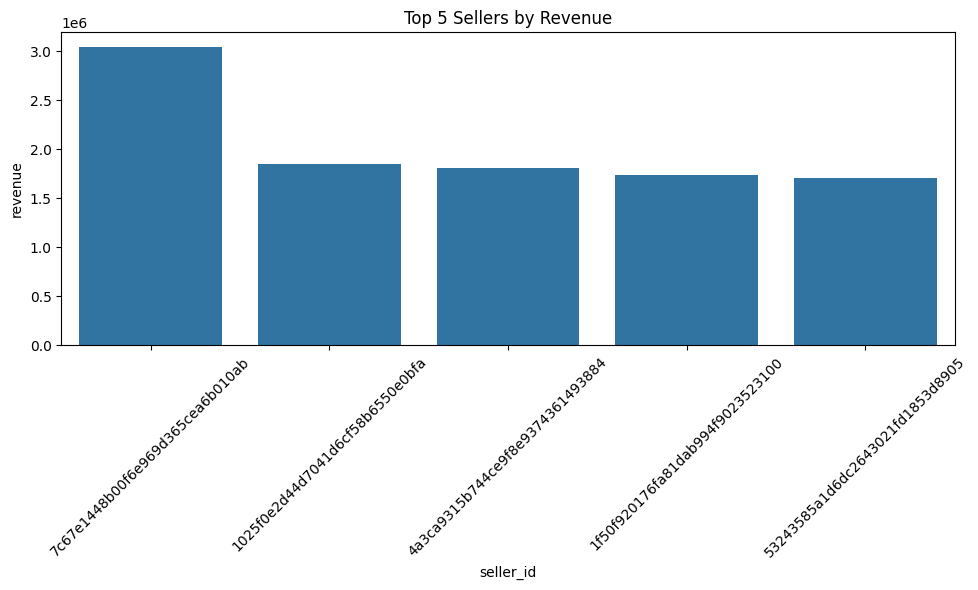

In [10]:

print("--Top 5 Sellers by Revenue ---")
query_6 = """
SELECT seller_id, revenue, DENSE_RANK() OVER (ORDER BY revenue DESC) AS rnk
FROM (
    SELECT oi.seller_id, SUM(pay.payment_value) AS revenue
    FROM order_items oi
    JOIN payments pay ON oi.order_id = pay.order_id
    GROUP BY oi.seller_id
) AS seller_revenue
"""
cur.execute(query_6)
data_6= cur.fetchall()
df_6 = pd.DataFrame(data_6, columns=["seller_id", "revenue", "rank"])
df_6_head = df_6.head()
print(df_6_head)

plt.figure(figsize=(10, 6))
sns.barplot(x="seller_id", y="revenue", data=df_6_head)
plt.xticks(rotation=45)
plt.title("Top 5 Sellers by Revenue")
plt.tight_layout()
plt.show()
print("\n" + "="*50 + "\n")


In [11]:
print("-- Moving Average of Order Values per Customer (First 10 Rows) ---")
query_7 = """
SELECT customer_id, order_purchase_timestamp, payment,
       AVG(payment) OVER (PARTITION BY customer_id ORDER BY order_purchase_timestamp ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS moving_avg
FROM (
    SELECT o.customer_id, o.order_purchase_timestamp, pay.payment_value AS payment
    FROM payments pay
    JOIN orders o ON pay.order_id = o.order_id
) AS customer_payments
"""
cur.execute(query_7)
data_7 = cur.fetchall()
df_7 = pd.DataFrame(data_7, columns=["customer_id", "timestamp", "payment", "moving_avg"])
print(df_7.head(10))
print("\n" + "="*50 + "\n")

-- Moving Average of Order Values per Customer (First 10 Rows) ---
                        customer_id            timestamp  payment  moving_avg
0  00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26   114.74      114.74
1  00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26   114.74      114.74
2  00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26   114.74      114.74
3  00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26   114.74      114.74
4  00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26   114.74      114.74
5  00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26   114.74      114.74
6  00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26   114.74      114.74
7  00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26   114.74      114.74
8  00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26   114.74      114.74
9  00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26   114.74      114.74




In [14]:
print("---Cumulative Sales by Month ---")
query_8 = """
SELECT years, months, monthly_payment,
       SUM(monthly_payment) OVER (ORDER BY years, months) AS cumulative_sales
FROM (
    SELECT YEAR(o.order_purchase_timestamp) AS years,
           MONTH(o.order_purchase_timestamp) AS months,
           ROUND(SUM(pay.payment_value), 2) AS monthly_payment
    FROM orders o
    JOIN payments pay ON o.order_id = pay.order_id
    GROUP BY years, months
) AS monthly_sales
ORDER BY years, months
"""
cur.execute(query_8)
data_8 = cur.fetchall()
df_8 = pd.DataFrame(data_8, columns=["year", "month", "payment", "cumulative_sales"])
print(df_8)
print("\n" + "="*50 + "\n")

---Cumulative Sales by Month ---
    year  month      payment  cumulative_sales
0   2016      9      5297.04      5.297040e+03
1   2016     10   1240900.08      1.246197e+06
2   2016     12       412.02      1.246609e+06
3   2017      1   2908248.84      4.154858e+06
4   2017      2   6130068.21      1.028493e+07
5   2017      3   9447135.60      1.973206e+07
6   2017      4   8773548.63      2.850561e+07
7   2017      5  12451295.22      4.095691e+07
8   2017      6  10736803.98      5.169371e+07
9   2017      7  12440041.32      6.413375e+07
10  2017      8  14162322.72      7.829607e+07
11  2017      9  15283011.45      9.357909e+07
12  2017     10  16373235.48      1.099523e+08
13  2017     11  25092538.80      1.350449e+08
14  2017     12  18446431.08      1.534913e+08
15  2018      1  23415087.78      1.769064e+08
16  2018      2  20841730.14      1.977481e+08
17  2018      3  24352694.52      2.221008e+08
18  2018      4  24376495.08      2.464773e+08
19  2018      5  24233625.1

In [15]:
print("--- Customer Retention Rate (within 6 months) ---")
query_9 = """
WITH first_orders AS (
    SELECT customer_id, MIN(order_purchase_timestamp) AS first_order_date
    FROM orders
    GROUP BY customer_id
),
retained_customers AS (
    SELECT DISTINCT f.customer_id
    FROM first_orders f
    JOIN orders o ON f.customer_id = o.customer_id
    WHERE o.order_purchase_timestamp > f.first_order_date
      AND o.order_purchase_timestamp <= DATE_ADD(f.first_order_date, INTERVAL 6 MONTH)
)
SELECT (COUNT(rc.customer_id) * 100.0) / COUNT(fo.customer_id) AS retention_rate_percentage
FROM first_orders fo
LEFT JOIN retained_customers rc ON fo.customer_id = rc.customer_id;
"""
cur.execute(query_9)
data_9 = cur.fetchall()
print(f"Customer Retention Rate: {data_9[0][0]:.2f}%")
print("\n" + "="*50 + "\n")

--- Customer Retention Rate (within 6 months) ---
Customer Retention Rate: 0.00%




--- Top 3 Customers by Spending per Year ---
   years                                id    payment  rank
0   2016  a9dc96b027d1252bbac0a9b72d837fc6   29894.55     1
1   2016  1d34ed25963d5aae4cf3d7f3a4cda173   29415.54     2
2   2016  4a06381959b6670756de02e07b83815f   25783.38     3
3   2017  1617b1357756262bfa56ab541c47bc16  286945.68     1
4   2017  c6e2731c5b391845f6800c97401a43a9  145515.51     2
5   2017  3fd6777bbce08a352fddd04e4a7cc8f6  141259.86     3
6   2018  ec5b2ba62e574342386871631fafd3fc  152772.48     1
7   2018  f48d464a0baaea338cb25f816991ab1f  145366.41     2
8   2018  e0a2412720e9ea4f26c1ac985f6a7358  100998.24     3


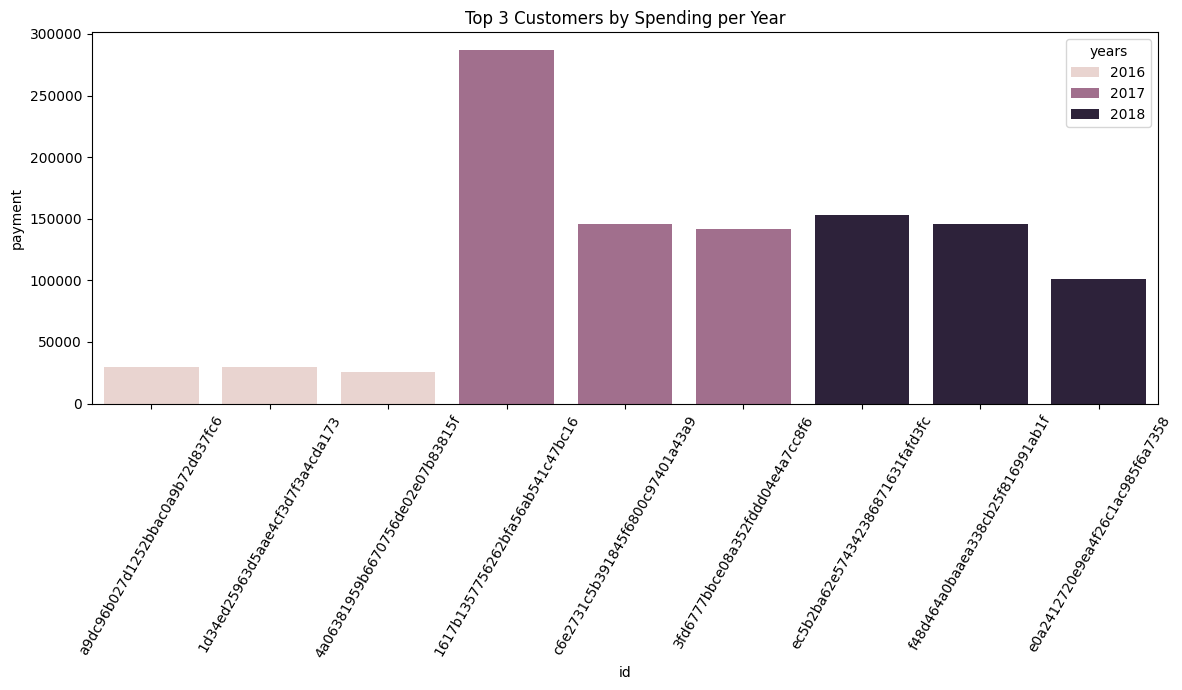

In [21]:
print("--- Top 3 Customers by Spending per Year ---")
query_10 = """
SELECT years, customer_id, payment, d_rank
FROM (
    SELECT YEAR(o.order_purchase_timestamp) AS years,
           o.customer_id,
           SUM(pay.payment_value) AS payment,
           DENSE_RANK() OVER (PARTITION BY YEAR(o.order_purchase_timestamp) ORDER BY SUM(pay.payment_value) DESC) AS d_rank
    FROM orders o
    JOIN payments pay ON pay.order_id = o.order_id
    GROUP BY years, o.customer_id
) AS ranked_customers
WHERE d_rank <= 3;
"""
cur.execute(query_10)
data_10 = cur.fetchall()
df_10 = pd.DataFrame(data_10, columns=["years", "id", "payment", "rank"])
print(df_10)

plt.figure(figsize=(12, 7))
sns.barplot(x="id", y="payment", data=df_10, hue="years")
plt.xticks(rotation=90)
plt.title("Top 3 Customers by Spending per Year")
plt.tight_layout()
plt.show()
print("\n" + "="*50 + "\n")

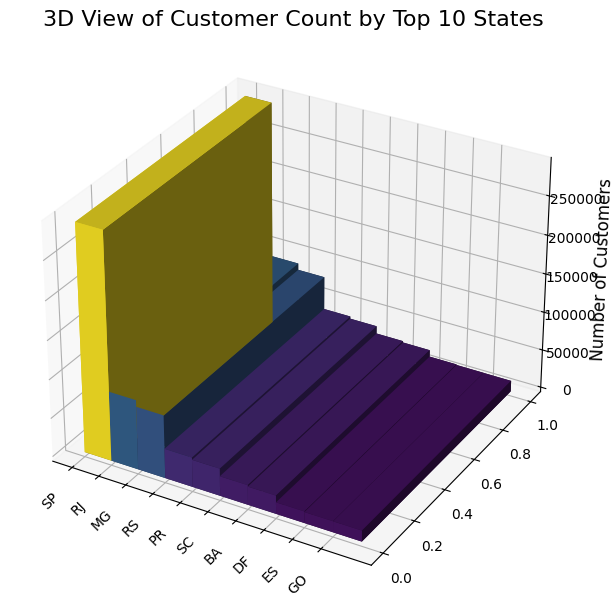

In [24]:


# Assuming 'cur' is your connected database cursor
query = """
    SELECT customer_state, COUNT(*) AS customer_count 
    FROM customers 
    GROUP BY customer_state 
    ORDER BY customer_count DESC
    LIMIT 10;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['state', 'count'])

fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(111, projection='3d')

x_pos = np.arange(len(df['state']))
y_pos = np.zeros(len(df['state']))
z_pos = np.zeros(len(df['state']))
x_size = np.ones(len(df['state']))
y_size = np.ones(len(df['state']))
z_size = df['count']

# Use a colormap to create a "3D coloring" effect
colors = plt.cm.viridis(df['count'] / float(max(df['count'])))
ax.bar3d(x_pos, y_pos, z_pos, x_size, y_size, z_size, color=colors)

ax.set_xticks(x_pos)
ax.set_xticklabels(df['state'], rotation=45, ha='right')
ax.set_title('3D View of Customer Count by Top 10 States', fontsize=16)
ax.set_zlabel('Number of Customers', fontsize=12)

# Replace tight_layout() with subplots_adjust() to fix the warning
fig.subplots_adjust(bottom=0.25)

plt.show()